## Imputed annotation summary statistics for different neuronal cell types

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from IPython.display import HTML
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation 
import numpy as np

import colorcet as cc
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from synapse_utils import io

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

run_id = 'synapseclr__so3__seed_42__second_stage'

checkpoint_path = f'../../output/checkpoint__{run_id}'
contamination_indices_path = '../../tables/meta_df_contamination_indices.npy'
reload_epoch = 99
node_idx_list = [0, 1, 2, 3]

imputed_cell_types_df_path = os.path.join(
    checkpoint_path, 'analysis', 'gp', 'synapse_simclr_consensus', 'consensus__meta__uncensored.csv')
imputed_meta_ext_df_path = os.path.join(
    checkpoint_path, 'analysis', 'gp', 'synapse_simclr_production', 'imputed_meta__rbf__synapse_simclr__ensemble.csv')

In [3]:
output_path = os.path.join(checkpoint_path, 'analysis', 'per_cell_type')
os.makedirs(output_path, exist_ok=True)

In [4]:
cell_type_int_to_label_map = {
    0: 'Ex',
    1: 'In'
}

# note: this is reversed from usual; DBSNP decided to order the clusters like this!
cluster_int_to_label_map = {
    0: 'In',
    1: 'Ex'
}

## Hierarchical clustering

In [5]:
import seaborn as sns
import colorcet as cc

In [6]:
raw_features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook='encoder.fc',
    dataset_path=dataset_path,
    l2_normalize=False,
    contamination_indices_path=contamination_indices_path)

In [7]:
def get_row_indices_from_synapse_ids(synapse_ids, meta_df):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

## Cell-type stratified summary statistics 

In [8]:
def get_cell_type_stats_reference(meta_df):
    counts = np.zeros((2, 2))
    for pre_cell_type in [0, 1]:
        for post_cell_type in [0, 1]:
            mask = (meta_df['pre_cell_type'] == pre_cell_type) & (meta_df['post_cell_type'] == post_cell_type)
            counts[pre_cell_type, post_cell_type] = np.sum(mask.values)
    return counts


def get_cell_type_stats_consensus(meta_df):
    counts = np.zeros((2, 2))
    for pre_cell_type in [0, 1]:
        for post_cell_type in [0, 1]:
            mask = (meta_df['pre_cell_type__consensus'] == pre_cell_type) & (meta_df['post_cell_type__consensus'] == post_cell_type)
            counts[pre_cell_type, post_cell_type] = np.sum(mask.values)
    return counts


def get_cell_type_stats_single_map(meta_df):
    counts = np.zeros((2, 2))
    pre_cell_type_naive_calls = (meta_df['imputed__pre_cell_type__class_1'] > 0.5).astype(int)
    post_cell_type_naive_calls = (meta_df['imputed__post_cell_type__class_1'] > 0.5).astype(int)
    for pre_cell_type in [0, 1]:
        for post_cell_type in [0, 1]:
            mask = (pre_cell_type_naive_calls == pre_cell_type) & (post_cell_type_naive_calls == post_cell_type)
            counts[pre_cell_type, post_cell_type] = np.sum(mask.values)
    return counts


def get_cell_type_stats_single_stochastic(meta_df):
    counts = np.zeros((2, 2))
    pre_cell_type_naive_calls = torch.distributions.Bernoulli(
        probs=torch.tensor(meta_df['imputed__pre_cell_type__class_1'].values)).sample([]).numpy().astype(int)
    post_cell_type_naive_calls = torch.distributions.Bernoulli(
        probs=torch.tensor(meta_df['imputed__post_cell_type__class_1'].values)).sample([]).numpy().astype(int)
    for pre_cell_type in [0, 1]:
        for post_cell_type in [0, 1]:
            mask = (pre_cell_type_naive_calls == pre_cell_type) & (post_cell_type_naive_calls == post_cell_type)
            counts[pre_cell_type, post_cell_type] = np.sum(mask)
    return counts

In [9]:
# reference ("manual")
reference_meta_ext_df = meta_ext_df.set_index('synapse_id')

# MLE consensus cell types
consensus_cell_types_df = pd.read_csv(imputed_cell_types_df_path, index_col=0).set_index('synapse_id')

# imputed annotations
imputed_meta_ext_df = pd.read_csv(imputed_meta_ext_df_path, index_col=0).set_index('synapse_id')

In [10]:
cell_type_counts__ref = get_cell_type_stats_reference(reference_meta_ext_df)
cell_type_counts__consensus = get_cell_type_stats_consensus(consensus_cell_types_df)
cell_type_counts__consensus_over_ref = get_cell_type_stats_consensus(consensus_cell_types_df.loc[reference_meta_ext_df.index])
cell_type_counts__single = get_cell_type_stats_single_map(imputed_meta_ext_df)
cell_type_counts__single_over_ref = get_cell_type_stats_single_map(imputed_meta_ext_df.loc[reference_meta_ext_df.index])

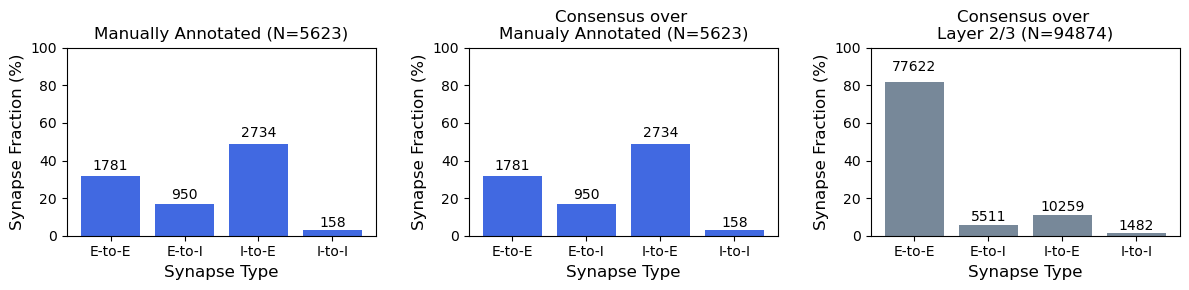

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3.))

def add_counts_to_ax(counts, ax, title, color):
    pct_counts = 100. * counts.flatten() / counts.sum()
    counts = counts.flatten()
    
    rects = ax.bar(np.arange(4), pct_counts, color=color)

    for i, rect in enumerate(rects):
        label = counts[i]
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(label),
                ha='center', va='bottom')
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['E-to-E', 'E-to-I', 'I-to-E', 'I-to-I'])
    ax.set_ylabel('Synapse Fraction (%)')
    ax.set_xlabel('Synapse Type')
    ax.set_ylim((0, 100))
    ax.set_title(title + f' (N={int(sum(counts))})', fontsize=12)
    
add_counts_to_ax(cell_type_counts__ref, axs[0], 'Manually Annotated', 'royalblue')
add_counts_to_ax(cell_type_counts__consensus_over_ref, axs[1], 'Consensus over \nManualy Annotated', 'royalblue')
add_counts_to_ax(cell_type_counts__consensus, axs[2], 'Consensus over \nLayer 2/3', 'lightslategray')

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
fig.savefig(os.path.join(output_path, 'synapse_type_fraction.pdf'), bbox_inches='tight')

## Per- cell-type global analysis

In [12]:
# load annotation transformation for inverse transformation to original units
loc_and_scale_df = pd.read_csv(
    os.path.join('../../tables/meta_ext_loc_scale.csv'), index_col=None)

# add missing
loc_and_scale_df['pre_synaptic_volume_log1p_zscore__loc'] = np.mean(np.log1p(meta_df['pre_synaptic_volume'].values))
loc_and_scale_df['pre_synaptic_volume_log1p_zscore__scale'] = np.std(np.log1p(meta_df['pre_synaptic_volume'].values))
loc_and_scale_df['post_synaptic_volume_log1p_zscore__loc'] = np.mean(np.log1p(meta_df['post_synaptic_volume'].values))
loc_and_scale_df['post_synaptic_volume_log1p_zscore__scale'] = np.std(np.log1p(meta_df['post_synaptic_volume'].values))

In [13]:
from synapse_utils.commons import load_imputed_annotations, log1p_zscore

# which annotations to use?
annotations_to_use = 'imputed'

if annotations_to_use == 'manual':
    analysis_meta_ext_df = meta_ext_df.copy()
    analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['pre_synaptic_volume'].values)
    analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['post_synaptic_volume'].values)
    output_subdir = 'manual/'

elif annotations_to_use == 'imputed':
    analysis_meta_ext_df = load_imputed_annotations(
    meta_df,
    imputed_cell_types_df_path,
    imputed_meta_ext_df_path)
    output_subdir = ''

In [14]:
global_continuous_trait_list = [
    'pre_synaptic_volume_log1p_zscore',
    'post_synaptic_volume_log1p_zscore',
    'cleft_size_log1p_zscore',
    'mito_size_pre_vx_log1p_zscore_zi',
    'mito_size_post_vx_log1p_zscore_zi',
    'presyn_soma_dist_log1p_zscore',
    'postsyn_soma_dist_log1p_zscore',
]

global_continuous_trait_conditional_list = [
    None,
    None,
    None,
    'has_mito_pre',
    'has_mito_post',
    None,
    None
]

global_continuous_trait_label_list = [
    'Pre-synaptic Volume (vx)',
    'Post-synaptic Volume (vx)',
    'Cleft Size (vx)',
    'Pre-synaptic Mitochondria Size (vx)',
    'Post-synaptic Mitochondria Size (vx)',
    'Pre-synaptic Soma Distance (um)',
    'Post-synaptic Soma Distance Size (um)'
]

global_binary_trait_label_list = [
    'Pre-synaptic Mitochondria Presence',
    'Post-synaptic Mitochondria Presence'
]

trait_scale_list = [
    64e-8,
    64e-8,
    64e-8,
    64e-8,
    64e-8,
    1.,
    1.,
]

In [15]:
global_statistics_dict = dict()

for pre_cell_type in [0, 1]:
    for post_cell_type in [0, 1]:

        global_statistics_dict[(pre_cell_type, post_cell_type)] = dict()
        local_statistics_dict = global_statistics_dict[(pre_cell_type, post_cell_type)]
        
        subset_synapse_indices = np.where(
            (analysis_meta_ext_df['pre_cell_type'].values == pre_cell_type) &
            (analysis_meta_ext_df['post_cell_type'].values == post_cell_type))[0]
        
        subset_meta_ext_df = analysis_meta_ext_df.iloc[subset_synapse_indices]

        # continuous traits
        for trait_key, trait_conditional, trait_label, trait_scale in zip(
                global_continuous_trait_list,
                global_continuous_trait_conditional_list,
                global_continuous_trait_label_list,
                trait_scale_list):

            loc = loc_and_scale_df[trait_key + '__loc'].item()
            scale = loc_and_scale_df[trait_key + '__scale'].item()

            log1p_zscore_values = subset_meta_ext_df[trait_key].values        
            values = trait_scale * (np.exp(log1p_zscore_values * scale + loc) - 1.)

            if trait_conditional is not None:
                control_mask = subset_meta_ext_df[trait_conditional].values > 0
                values = values[control_mask]

            local_statistics_dict[trait_label] = values
            
        # binary traits
        n_total = len(subset_meta_ext_df)
        
        local_statistics_dict['Pre-synaptic Mitochondria Presence'] = 100. * np.sum(subset_meta_ext_df['has_mito_pre'] == 1) / n_total
        local_statistics_dict['Post-synaptic Mitochondria Presence'] = 100. * np.sum(subset_meta_ext_df['has_mito_post'] == 1) / n_total

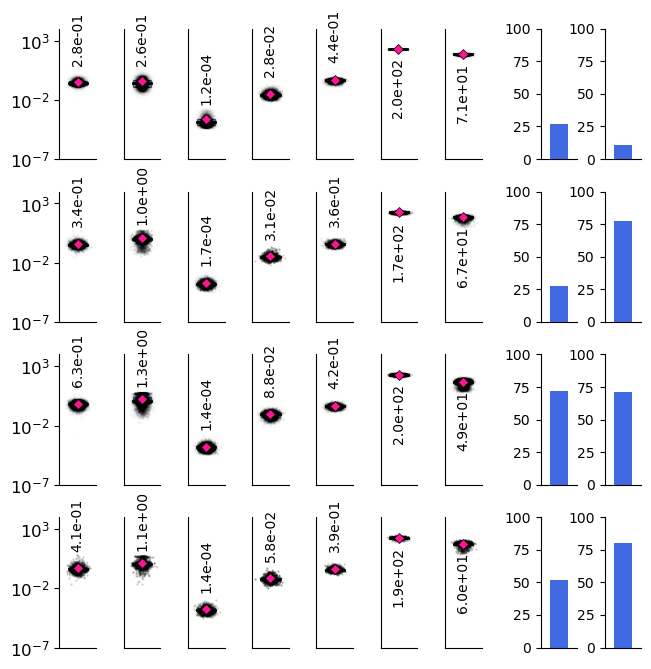

In [16]:
from matplotlib import gridspec

n_columns = len(global_continuous_trait_list)
n_extra = len(global_binary_trait_label_list)
n_groups = len(global_statistics_dict)

tick_fontsize = 10

fig = plt.figure(figsize=(0.7 * (n_columns + n_extra), 1.7 * n_groups))
gs = gridspec.GridSpec(n_groups, n_columns + n_extra)

axs = dict()
for i_column in range(n_columns):    
    ax = fig.add_subplot(gs[0, i_column])
    axs[(0, i_column)] = ax
    for i_group in range(1, n_groups):
        ax2 = fig.add_subplot(gs[i_group, i_column], sharey=ax)
        axs[(i_group, i_column)] = ax2

for ax in axs.values():
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', labelsize=tick_fontsize)

for i_group in range(n_groups):
    for i_column in range(n_columns, n_columns + n_extra):
        ax_bar = fig.add_subplot(gs[i_group, i_column])
        axs[(i_group, i_column)] = ax_bar

hi = 5000
lo = 0.0005

for i_group, group_key in enumerate(global_statistics_dict.keys()):    
    
    # continuous
    for i_column, (column_name, ymax, yticks, h) in enumerate(zip(
            global_continuous_trait_label_list,
            [2e6, 1e7, 1e3, 5e5, 2e6, 5e2, 2e2],
            [2, 1, 1, 5, 2, 5, 2],
            [hi, hi, hi, hi, hi, lo, lo])):

        ax = axs[(i_group, i_column)]
        data = global_statistics_dict[group_key][column_name]

        bp = ax.boxplot(data, showfliers=False, whis=0., widths=0.5, showmeans=True, patch_artist=True)

        for patch in bp['boxes']:
            patch.set_facecolor('royalblue')
            patch.set_alpha(0.5)

        for median in bp['medians']:
            median.set(color='black', linewidth=2)
            median_value = median.get_ydata()[0]
            ax.text(1, median_value * h,
                    '%.1e' % float(median_value),
                    ha='center', va='center', rotation=90)
            
        for mean in bp['means']:
            mean.set_markeredgecolor('black')
            mean.set_markerfacecolor('deeppink')
            mean.set_marker('D')
            mean.set_markersize(5)
            mean.set_markeredgewidth(0.5)

        x = np.random.normal(1, 0.1, size=len(data))
        ax.plot(x, data, '.', color='black', alpha=min(1., 300. / len(data)), markersize=1, rasterized=True)
        ax.set_yticks(np.arange(0, yticks + 1) * (ymax/yticks))
        ax.set_xticks([])
        ax.set_yscale('log')
        ax.tick_params(axis='y', labelsize=12)
        ax.set_ylim((1e-7, 1e4))
        locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9), numticks=4)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        
        if i_column > 0:
            ax.set_yticks([])


    # binary
    for i_column in range(n_columns, n_columns + n_extra):

        ax = axs[(i_group, i_column)]
        column_name = global_binary_trait_label_list[i_column - n_columns]
        data = global_statistics_dict[group_key][column_name]

        ax.set_xticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_ylim((0, 100))
        ax.tick_params(axis='y', labelsize=tick_fontsize)

        ax.bar(
            [0],
            data,
            color=['royalblue'],
            width=0.5)
        
        ax.set_xlim((-0.5, 0.5))

        
fig.tight_layout()
fig.subplots_adjust(wspace=0.75, hspace=0.25)


for i_group, group_key in enumerate(global_statistics_dict.keys()):    
    
    # binary
    for i_column in range(n_columns, n_columns + n_extra):

        ax = axs[(i_group, i_column)]
        
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0 + 0.05, pos1.y0,  pos1.width, pos1.height] 
        ax.set_position(pos2)
        
        
fig.savefig(os.path.join(output_path, f'global_statistics__{annotations_to_use}.pdf'), bbox_inches='tight')

## Per- cell-type correlation analysis

In [17]:
corr_trait_list = [
    'pre_synaptic_volume_log1p_zscore',
    'post_synaptic_volume_log1p_zscore',
    'cleft_size_log1p_zscore',
    'mito_size_pre_vx_log1p_zscore_zi',
    'mito_size_post_vx_log1p_zscore_zi',
    'presyn_soma_dist_log1p_zscore',
    'postsyn_soma_dist_log1p_zscore',
]

corr_trait_conditional_list = [
    None,
    None,
    None,
    'has_mito_pre',
    'has_mito_post',
    None,
    None
]

corr_trait_label_list = [
    'Pre-synaptic Volume (vx)',
    'Post-synaptic Volume (vx)',
    'Cleft Size (vx)',
    'Pre-synaptic Mitochondria Size (vx)',
    'Post-synaptic Mitochondria Size (vx)',
    'Pre-synaptic Soma Distance (vx)',
    'Post-synaptic Soma Distance Size (vx)'
]

corr_short_label_list = [
    'PreVol',
    'PostVol',
    'Cleft',
    'PreMitoVol',
    'PostMitoVol',
    'PreDist',
    'PostDist'
]

In [18]:
from synapse_utils.commons import load_imputed_annotations_stochastic
from scipy.stats import spearmanr
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch

pre_cell_type = 0
post_cell_type = 0
n_trials = 20

# which annotations to use?
annotations_to_use = 'imputed'

n_corr_traits = len(corr_trait_list)
sp_corr_matrix = np.zeros((n_corr_traits, n_corr_traits))

for i_trial in range(n_trials):
    
    if annotations_to_use == 'manual':
        analysis_meta_ext_df = meta_ext_df.copy()
        analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['pre_synaptic_volume'].values)
        analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['post_synaptic_volume'].values)

    elif annotations_to_use == 'imputed':
        analysis_meta_ext_df = load_imputed_annotations_stochastic(
        meta_df,
        imputed_cell_types_df_path,
        imputed_meta_ext_df_path)

    subset_synapse_indices = np.where(
        (analysis_meta_ext_df['pre_cell_type'].values == pre_cell_type) &
        (analysis_meta_ext_df['post_cell_type'].values == post_cell_type))[0]

    subset_meta_ext_df = analysis_meta_ext_df.iloc[subset_synapse_indices]
    

    for i in range(n_corr_traits):
        for j in range(n_corr_traits):

            v1 = subset_meta_ext_df[corr_trait_list[i]].values
            v2 = subset_meta_ext_df[corr_trait_list[j]].values

            sp_corr_matrix[i, j] += spearmanr(v1, v2).correlation
        
sp_corr_matrix = sp_corr_matrix / n_trials

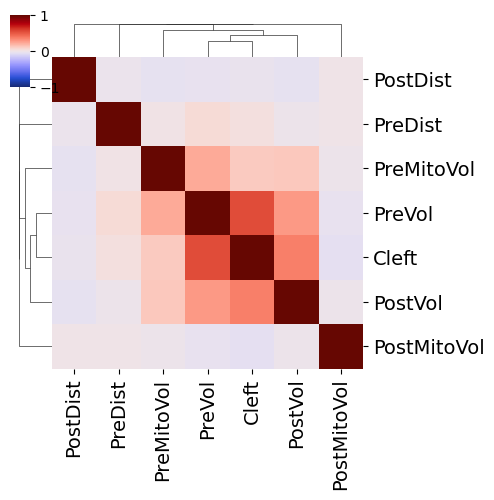

In [19]:
import seaborn as sns
import colorcet as cc

corr_condensed = distance.squareform(1. - np.abs(sp_corr_matrix), checks=False)
linkage = sch.linkage(corr_condensed, method='single', optimal_ordering=True)

cg = sns.clustermap(
    sp_corr_matrix,
    row_linkage=linkage,
    col_linkage=linkage,
    cmap=cc.diverging_bwr_20_95_c54,
    figsize=(4, 4),
    vmin=-1,
    vmax=1,
    dendrogram_ratio=0.1)

reordered_labels = np.asarray(corr_short_label_list)[cg.dendrogram_row.reordered_ind].tolist()
cg.ax_heatmap.set(
    xticks=np.arange(len(reordered_labels)) + 0.5,
    xticklabels=reordered_labels);
cg.ax_heatmap.set(
    yticks=np.arange(len(reordered_labels)) + 0.5,
    yticklabels=reordered_labels);
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=14);
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=14);

cg.savefig(os.path.join(output_path, f'corr__{pre_cell_type}_{post_cell_type}__{annotations_to_use}.pdf'))